<a href="https://colab.research.google.com/github/mertakpinar29/flagstudy/blob/main/flagstudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -q flags.zip -d /content

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report, make_scorer
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, ParameterGrid, ShuffleSplit, KFold
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import preprocessing, decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from mlxtend.evaluate import feature_importance_permutation
import tensorflow as tf
from keras import Input # for instantiating a keras tensor

In [ ]:
# if header is not None, library recognizes first row as header
ds_flags = pd.read_csv('/content/flag.data', header = None)
print('Shape of dataframe: ', ds_flags.shape)
ds_flags.head()

Shape of dataframe:  (194, 30)


0   1   2     3   4   5   6   7   8   9   ...  20  21  22  23  \
0     Afghanistan   5   1   648  16  10   2   0   3   5  ...   0   0   1   0   
1         Albania   3   1    29   3   6   6   0   0   3  ...   0   0   1   0   
2         Algeria   4   1  2388  20   8   2   2   0   3  ...   0   0   1   1   
3  American-Samoa   6   3     0   0   1   1   0   0   5  ...   0   0   0   0   
4         Andorra   3   1     0   0   6   0   3   0   3  ...   0   0   0   0   

   24  25  26 27     28     29  
0   0   1   0  0  black  green  
1   0   0   1  0    red    red  
2   0   0   0  0  green  white  
3   1   1   1  0   blue    red  
4   0   0   0  0   blue    red  

[5 rows x 30 columns]

In [ ]:
# check if null values exist in dataset
ds_flags.isnull().sum()

# reassignin values of religion column
ds_flags[6] = ds_flags[6].astype('category')
ds_flags[6].replace({0: 'Catholic', 1: 'Other Christian', 2: "Muslim", 3: 'Buddhist', 4: 'Hindu', 5: 'Ethnic', 6: 'Marxist', 7: 'Others'}, inplace=True)
print(ds_flags[6])

0               Muslim
1              Marxist
2               Muslim
3      Other Christian
4             Catholic
            ...       
189    Other Christian
190            Marxist
191             Ethnic
192             Ethnic
193             Ethnic
Name: 6, Length: 194, dtype: category
Categories (8, object): ['Catholic', 'Other Christian', 'Muslim', 'Buddhist', 'Hindu', 'Ethnic',
                         'Marxist', 'Others']


In [ ]:
# creating a subset of dataset with only flag charasteristics and renaming the columns
flag_class = ds_flags.iloc[:, 6:30]
flag_class.rename(columns={6: 'religion', 7: 'bars', 8: 'stripes', 9: 'colours', 10: 'red', 11: 'green', 12: 'blue', 13: 'gold', 14: 'white', 15: 'black', 16: 'orange', 17: 'mainhue', 18: 'circles', 19: 'crosses', 20: 'saltires', 21: 'quarters', 22: 'sunstars', 23: 'crescent', 24: 'triangle', 25: 'icon', 26: 'animate', 27: 'text', 28: 'topleft', 29: 'botright'}, inplace=True)

In [ ]:
# Categorical columns
flag_class['red'] = pd.Categorical(flag_class['red'])
flag_class['green'] = pd.Categorical(flag_class['green'])
flag_class['blue'] = pd.Categorical(flag_class['blue'])
flag_class['gold'] = pd.Categorical(flag_class['gold'])
flag_class['white'] = pd.Categorical(flag_class['white'])
flag_class['black'] = pd.Categorical(flag_class['black'])
flag_class['orange'] = pd.Categorical(flag_class['orange'])
flag_class['mainhue'] = pd.Categorical(flag_class['mainhue'])
flag_class['crescent'] = pd.Categorical(flag_class['crescent'])
flag_class['triangle'] = pd.Categorical(flag_class['triangle'])
flag_class['animate'] = pd.Categorical(flag_class['animate'])
flag_class['text'] = pd.Categorical(flag_class['text'])
flag_class['topleft'] = pd.Categorical(flag_class['topleft'])
flag_class['botright'] = pd.Categorical(flag_class['botright'])

# Integer columns
flag_class['bars'] = flag_class['bars'].astype(int)
flag_class['stripes'] = flag_class['stripes'].astype(int)
flag_class['colours'] = flag_class['colours'].astype(int)
flag_class['circles'] = flag_class['circles'].astype(int)
flag_class['crosses'] = flag_class['crosses'].astype(int)
flag_class['saltires'] = flag_class['saltires'].astype(int)
flag_class['quarters'] = flag_class['quarters'].astype(int)
flag_class['sunstars'] = flag_class['sunstars'].astype(int)

print(flag_class.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   religion  194 non-null    category
 1   bars      194 non-null    int64   
 2   stripes   194 non-null    int64   
 3   colours   194 non-null    int64   
 4   red       194 non-null    category
 5   green     194 non-null    category
 6   blue      194 non-null    category
 7   gold      194 non-null    category
 8   white     194 non-null    category
 9   black     194 non-null    category
 10  orange    194 non-null    category
 11  mainhue   194 non-null    category
 12  circles   194 non-null    int64   
 13  crosses   194 non-null    int64   
 14  saltires  194 non-null    int64   
 15  quarters  194 non-null    int64   
 16  sunstars  194 non-null    int64   
 17  crescent  194 non-null    category
 18  triangle  194 non-null    category
 19  icon      194 non-null    int64   
 20  animate   

In [ ]:
# Visualization of some of the attributes of flag data
religion_sorted = pd.DataFrame(ds_flags[6].value_counts()).reset_index()
religion_sorted.columns = ['Value', 'Frequency']
religion_sorted = religion_sorted.sort_values(by='Frequency', ascending=False)
religion_sorted['Value'] = pd.Categorical(religion_sorted['Value'], categories=religion_sorted['Value'].unique(), ordered=True)

fig = px.bar(religion_sorted, x='Value', y='Frequency', title='Religions and Flags',
             labels={'Value': 'Religion', 'Frequency': 'Number of Flags'},
             color_discrete_sequence=['rgb(158,202,225)'])

fig.update_traces(marker_line_color='rgb(255,255,255)', marker_line_width=6.0)

fig.show()

bars_sorted = pd.DataFrame(ds_flags[7].value_counts()).reset_index()
bars_sorted.columns = ['Value', 'Frequency']
bars_sorted = bars_sorted.sort_values(by='Frequency', ascending=False)
bars_sorted['Value'] = pd.Categorical(bars_sorted['Value'], categories=bars_sorted['Value'].unique(), ordered=True)

fig = px.bar(bars_sorted, x='Value', y='Frequency', title='Vertical number of bars',
             labels={'Value': 'Bars', 'Frequency': 'Number of Flags'},
             color_discrete_sequence=['rgb(158,202,225)'])

fig.update_traces(marker_line_color='rgb(255,255,255)', marker_line_width=6.0)

fig.show()

colours_sorted = pd.DataFrame(ds_flags[17].value_counts()).reset_index()
colours_sorted.columns = ['Value', 'Frequency']
colours_sorted = colours_sorted.sort_values(by='Frequency', ascending=False)
colours_sorted['Value'] = pd.Categorical(colours_sorted['Value'], categories=colours_sorted['Value'].unique(), ordered=True)

fig = px.bar(colours_sorted, x='Value', y='Frequency', title='Main Hue Color',
             labels={'Value': 'Colours', 'Frequency': 'Number of Flags'},
             color_discrete_sequence=['rgb(158,202,225)'])

fig.update_traces(marker_line_color='rgb(255,255,255)', marker_line_width=6.0)

fig.show()

In [ ]:
# independent variables
X = flag_class.drop('religion', axis=1)
y = flag_class['religion']

# conversion of categorical variables to numeric
label_encoder = preprocessing.LabelEncoder()
for column in X.select_dtypes(include=['category']).columns:
  X[column] = label_encoder.fit_transform(X[column])

y_encoded = label_encoder.fit_transform(y.copy())

# splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# create the classifier
treeFit = DecisionTreeClassifier(criterion='gini')
treeFit.fit(X_train, y_train)

print('Training accuracy: ', np.mean(treeFit.predict(X_train) == y_train)*100)
print('Test accuracy: ', np.mean(treeFit.predict(X_test) == y_test)*100)
print('Depth of the tree: ', treeFit.tree_.max_depth)

# visualize the tree
plt.figure(figsize=(300,100))
plot_tree(treeFit, filled=True, feature_names=X.columns, class_names=y.unique(), rounded=True, fontsize=15)
plt.title("Initial Classification Tree")
plt.show()

5               Ethnic
135           Catholic
122    Other Christian
167             Muslim
85            Catholic
            ...       
106             Muslim
14              Muslim
92            Buddhist
179             Ethnic
102           Catholic
Name: religion, Length: 155, dtype: category
Categories (8, object): ['Catholic', 'Other Christian', 'Muslim', 'Buddhist', 'Hindu', 'Ethnic',
                         'Marxist', 'Others']
Training accuracy:  98.06451612903226
Test accuracy:  33.33333333333333
Depth of the tree:  13


In [ ]:
# accuracy
# kfold
k_fold_dt_score = cross_val_score(DecisionTreeClassifier(), X, y, cv=5)
print(k_fold_dt_score)

print('Test accuracy: ', np.average(k_fold_dt_score))

[0.38461538 0.43589744 0.17948718 0.48717949 0.47368421]
Test accuracy:  0.3921727395411606


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



In [ ]:
# Creating a best depth tree
max_depth = treeFit.get_depth()
max_depth_grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    scoring=make_scorer(accuracy_score),
    param_grid=ParameterGrid(
        { 'max_depth': [[max_depth] for max_depth in range(1, max_depth + 1)] }
    )
)
max_depth_grid_search.fit(X, y)
best_max_depth_tree = max_depth_grid_search.best_estimator_
# print("efficient maximum depth: ", best_max_depth_tree.get_depth())

# kfold
k_fold_bdt_score = cross_val_score(best_max_depth_tree, X, y, cv=5)

print('Test accuracy with k-fold: ', np.average(k_fold_bdt_score))

# visualize the tree
plt.figure(figsize=(200,50))
plot_tree(best_max_depth_tree, filled=True, feature_names=X.columns, class_names=y.unique(), rounded=True, fontsize=12)
plt.title("Max Depth Classification Tree")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



efficient maximum depth:  11
[0.43589744 0.48717949 0.30769231 0.46153846 0.47368421]
Test accuracy with k-fold:  0.4331983805668017


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



Training accuracy:  76.12903225806451
Test accuracy:  51.28205128205128
     Feature  Importance
12   crosses    0.085897
22  botright    0.063077
5       blue    0.038462
6       gold    0.035641
0       bars    0.035641
7      white    0.034359
1    stripes    0.029487
8      black    0.024872
2    colours    0.022821
4      green    0.021282
17  triangle    0.015897
3        red    0.006410
16  crescent    0.006154
14  quarters    0.005385
15  sunstars    0.001282
20      text   -0.000769
19   animate   -0.002051
9     orange   -0.002308
18      icon   -0.003077
11   circles   -0.007436
13  saltires   -0.009487
21   topleft   -0.014103
10   mainhue   -0.020256


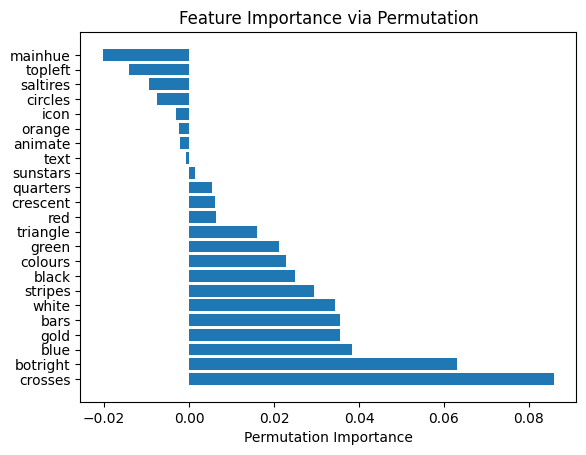

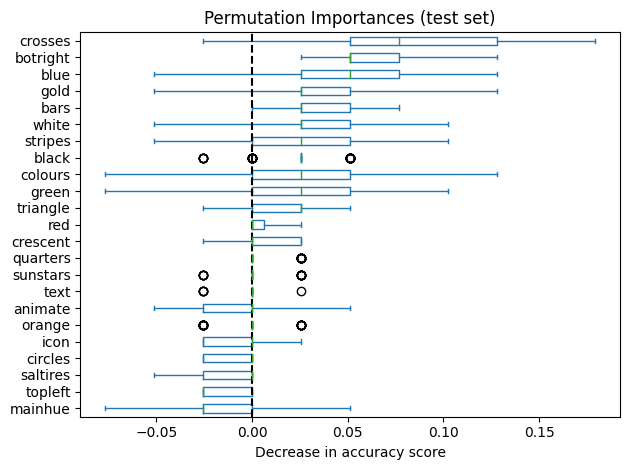

In [ ]:
# Tree model with variable selection with Random Forest feature importance
rf = RandomForestClassifier(n_estimators=50, criterion='gini', random_state=42, min_samples_split=10)
rf.fit(X_train, y_train)

print('Training accuracy: ', np.mean(rf.predict(X_train) == y_train)*100)
print('Test accuracy: ', np.mean(rf.predict(X_test) == y_test)*100)

# Calculate permutation importance
perm_importance = permutation_importance(estimator=rf, X=X_test, y=y_test, scoring='accuracy', n_repeats=100, random_state=42)
feature_names = X.columns
perm_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': perm_importance.importances_mean})
sorted_perm_importance = perm_importance_df.sort_values(by='Importance', ascending=False)
# print(sorted_perm_importance)

# Visualize importance values
plt.barh(sorted_perm_importance['Feature'], sorted_perm_importance['Importance'])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance via Permutation')
plt.show()

sorted_importances_idx = perm_importance.importances_mean.argsort()
importances = pd.DataFrame(
    perm_importance.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [ ]:
# Retrieve important columns
selected_features = []
for i in range(len(sorted_perm_importance)):
  if sorted_perm_importance.Importance[i] > 0:
    selected_features.append(sorted_perm_importance.Feature[i])

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

rf_selected = RandomForestClassifier(n_estimators=50, random_state=42, min_samples_split=12)
rf_selected.fit(X_train_selected, y_train)

y_pred = rf_selected.predict(X_test_selected)
print('Training accuracy: ', np.mean(rf_selected.predict(X_train_selected) == y_train)*100)
print('Test accuracy: ', np.mean(rf_selected.predict(X_test_selected) == y_test)*100)

print(selected_features)

Training accuracy:  69.03225806451613
Test accuracy:  56.41025641025641
['bars', 'stripes', 'colours', 'red', 'green', 'blue', 'gold', 'white', 'black', 'crosses', 'quarters', 'sunstars', 'crescent', 'triangle', 'botright']


In [ ]:
# SVM
# param_grid = { 'C': np.arange(0, 101),
#               'gamma': np.arange(0, 3.1, 0.1)}

# grid_search = GridSearchCV(svm, param_grid, cv=10)

# # Fit the model to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best estimator
# best_params = grid_search.best_params_
# best_estimator = grid_search.best_estimator_

# print("best params: ", best_params)
# print("best estimator: ", best_estimator)

# create svm classifier
svm = SVC(C=2, gamma=0.6)


# Fit the model to the best SVM
svm.fit(X_train_selected, y_train)

# Evaluate the model on the test set
print('Training accuracy: ', np.mean(svm.predict(X_train_selected) == y_train)*100)
print('Test accuracy: ', np.mean(svm.predict(X_test_selected) == y_test)*100)

Training accuracy:  96.7741935483871
Test accuracy:  61.53846153846154


Number of nodes in the last tree is: 1 with ccp_alpha: 0.05007743184520708


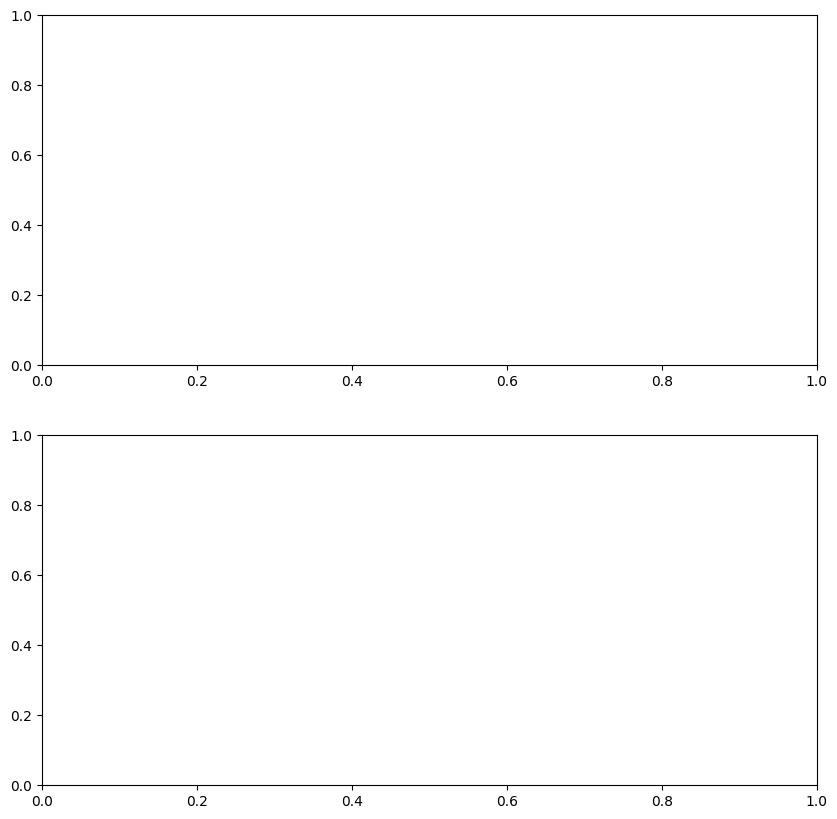

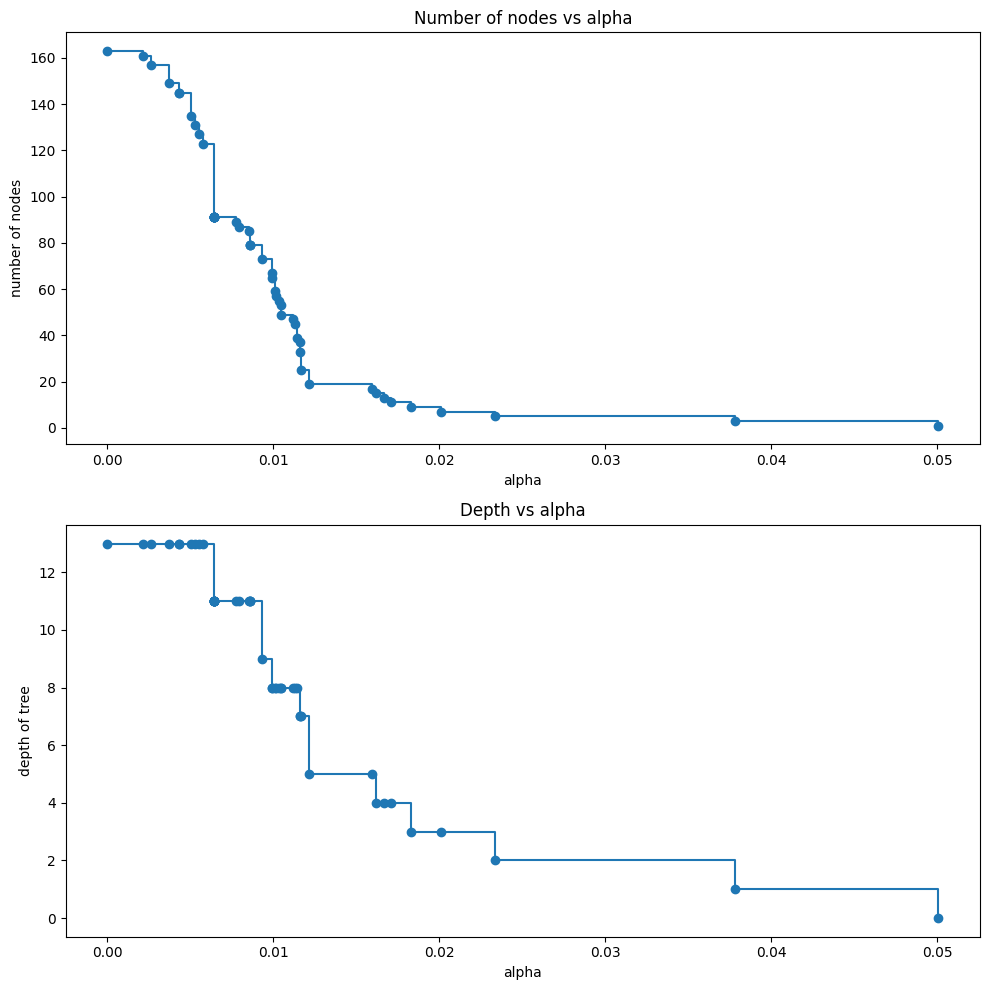

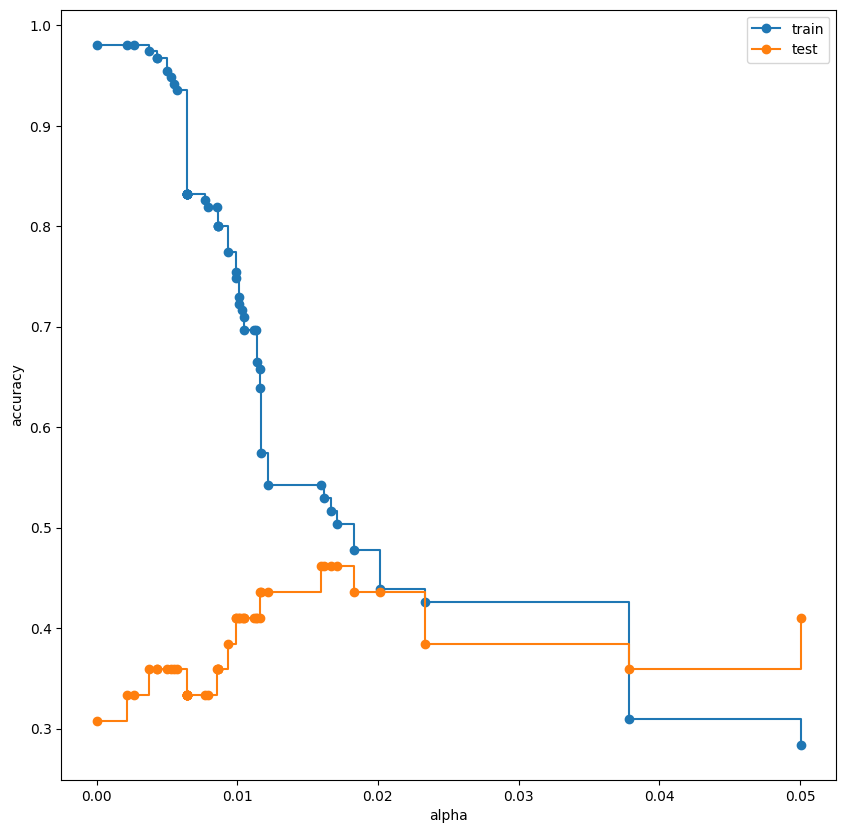

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



{'ccp_alpha': 0.007741935483870968}
DecisionTreeClassifier(ccp_alpha=0.007741935483870968, random_state=42)


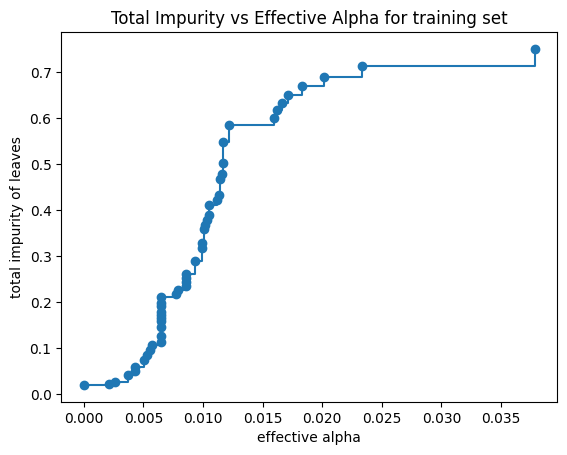

Training accuracy:  82.58064516129032
Test accuracy:  33.33333333333333
[0.56410256 0.38461538 0.30769231 0.51282051 0.42105263]
Test accuracy with k-fold:  0.4380566801619433


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



In [ ]:
path = treeFit.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ccp_alpha_grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    scoring=make_scorer(accuracy_score),
    param_grid=ParameterGrid({'ccp_alpha': [[alpha] for alpha in ccp_alphas]})
)

clf_dts = [] #created an array to put decision tree into
for ccp_alpha in ccp_alphas :
    clf=DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
    clf.fit(X_train, y_train)
    clf_dts.append(clf)

print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clf_dts[-1].tree_.node_count, ccp_alphas[-1]
    ))

train_scores= [ clf.score(X_train, y_train ) for  clf in clf_dts]
test_scores = [clf.score(X_test, y_test) for clf in clf_dts]
node_counts = [clf.tree_.node_count for clf in clf_dts]
depth = [clf.tree_.max_depth for clf in clf_dts]
fig, ax = plt.subplots(2, 1, figsize =(10,10))
fig, ax = plt.subplots(2, 1, figsize =(10,10))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.plot(ccp_alphas, train_scores, marker = 'o' , label='train', drawstyle = 'steps-post')
ax.plot(ccp_alphas, test_scores, marker = 'o' , label='test', drawstyle = 'steps-post')

ax.legend()
plt.show()
ccp_alpha_grid_search.fit(X_train, y_train)

best_ccp_alpha_tree = ccp_alpha_grid_search.best_estimator_

# Plot the pruning path
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs Effective Alpha for training set")

# Visualize the pruned tree
plt.figure(figsize=(200, 50))
plot_tree(best_ccp_alpha_tree, filled=True, feature_names=X.columns, class_names=best_ccp_alpha_tree.classes_, rounded=True, fontsize=20)
plt.title("Pruned Decision Tree")
plt.show()

y_pred_pfit = best_ccp_alpha_tree.predict(X_test)
accuracy_pfit = accuracy_score(y_test, y_pred_pfit)
print('Training accuracy: ', np.mean(best_ccp_alpha_tree.predict(X_train) == y_train)*100)
print('Test accuracy: ', np.mean(best_ccp_alpha_tree.predict(X_test) == y_test)*100)


# kfold
k_fold_bat_score = cross_val_score(best_ccp_alpha_tree, X, y, cv=5)
print(k_fold_bat_score)

print('Test accuracy with k-fold: ', np.average(k_fold_bat_score))


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

model = GradientBoostingClassifier(n_estimators=50, min_samples_leaf=10)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f)' % (np.mean(n_scores)))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=10.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=10.

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=10.



Accuracy: 0.467)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
# Standardize the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Create a simple feed-forward neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(32, activation='relu'),
    BatchNormalization(),

    Dense(len(set(y_train)), activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on the test set
y_pred_prob = model.predict(X_test_scaled)
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for Feed-Forward Neural Network: {accuracy}")

Epoch 1/10
5/5 [==============================] - 3s 96ms/step - loss: 2.5973 - accuracy: 0.1295 - val_loss: 2.0732 - val_accuracy: 0.1875
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 2.5805 - accuracy: 0.1871 - val_loss: 2.0245 - val_accuracy: 0.1875
Epoch 3/10
5/5 [==============================] - 0s 10ms/step - loss: 2.4647 - accuracy: 0.1799 - val_loss: 1.9908 - val_accuracy: 0.3125
Epoch 4/10
5/5 [==============================] - 0s 10ms/step - loss: 2.5022 - accuracy: 0.1151 - val_loss: 1.9592 - val_accuracy: 0.3125
Epoch 5/10
5/5 [==============================] - 0s 10ms/step - loss: 2.4278 - accuracy: 0.1799 - val_loss: 1.9318 - val_accuracy: 0.3750
Epoch 6/10
5/5 [==============================] - 0s 10ms/step - loss: 2.2157 - accuracy: 0.2230 - val_loss: 1.9095 - val_accuracy: 0.3750
Epoch 7/10
5/5 [==============================] - 0s 10ms/step - loss: 2.1890 - accuracy: 0.2158 - val_loss: 1.8866 - val_accuracy: 0.3750
Epoch 8/10
5/5 [===========